# NDSSL Node Classification - Age

**To Do**:
- Wy is the GCN/graphSAGE approach so fast/why is the MLP approach so slow?
- The MPNN approaches beat the MLP approach, but neither are as good as I expected
- I tried using class weights, and results aren't great
- does it learn that everyone in a household has the same income?
- add more descriptive text

In [1]:
import torch
from torch_geometric.data import Data, InMemoryDataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, SAGEConv
from torch_geometric.data import GraphSAINTRandomWalkSampler
from torch_geometric.utils import get_laplacian, degree
import pandas as pd
import numpy as np
import itertools
from tqdm.auto import tqdm, trange

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.style as style 
style.use('seaborn-paper')

fontsize = 12
plt.rcParams.update({
    'font.size': fontsize, 
    'axes.labelsize': fontsize, 
    'legend.fontsize': fontsize,
    'xtick.labelsize': fontsize,
    'ytick.labelsize': fontsize,
    'axes.titlesize': fontsize
                    })

In [2]:
#from imports import *
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
#device = 'cpu'
print(device)

cpu


## Data processing

Convert the node attribute data into an (x,y) format

In [3]:
node_attributes = pd.read_csv('../../data/NDSSL data/raw/node_attributes.csv')

## one-hot encode gender
gender_index = torch.LongTensor(node_attributes['gender'].values - 1).type(torch.int64).reshape((len(node_attributes), 1))
gender_onehot = torch.LongTensor(len(node_attributes), 2)
gender_onehot.zero_()
gender_onehot = gender_onehot.scatter_(1, gender_index, 1).type(torch.float32);

## one-hot encode worker
worker_index = torch.LongTensor(node_attributes['worker'].values - 1).type(torch.int64).reshape((len(node_attributes), 1))
worker_onehot = torch.LongTensor(len(node_attributes), 2)
worker_onehot.zero_()
worker_onehot = worker_onehot.scatter_(1, worker_index, 1).type(torch.float32);

## map the 117 distinct zipcodes to the integers 0, ..., 116
zipcode_original = node_attributes['zipcode'].values
zipcode_dict = {i: j for j, i in enumerate(set(zipcode_original))} 
zipcode_index = torch.LongTensor(np.asarray([zipcode_dict[i] for i in zipcode_original])).type(torch.int64).reshape((len(node_attributes), 1))

## one-hot encode zipcode
zipcode_onehot = torch.LongTensor(len(node_attributes), len(zipcode_dict))
zipcode_onehot.zero_()
zipcode_onehot = zipcode_onehot.scatter_(1, zipcode_index, 1).type(torch.float32);

## one-hot encode household income
household_income_index = torch.LongTensor(node_attributes['household_income'].values - 1).type(torch.int64).reshape((len(node_attributes), 1))
household_income_onehot = torch.LongTensor(len(node_attributes), 14)
household_income_onehot.zero_()
household_income_onehot = household_income_onehot.scatter_(1, household_income_index, 1).type(torch.float32);

## one-hot encode relationship
relationship_index = torch.LongTensor(node_attributes['relationship'].values - 1).type(torch.int64).reshape((len(node_attributes), 1))
relationship_onehot = torch.LongTensor(len(node_attributes), 4)
relationship_onehot.zero_()
relationship_onehot = relationship_onehot.scatter_(1, relationship_index, 1).type(torch.float32);

age = torch.FloatTensor(node_attributes['age'].values).reshape(len(node_attributes), 1).type(torch.float32)
household_size = torch.FloatTensor(node_attributes['household_size'].values).reshape(len(node_attributes), 1).type(torch.float32)
household_workers = torch.FloatTensor(node_attributes['household_workers'].values).reshape(len(node_attributes), 1).type(torch.float32)
household_vehicles = torch.FloatTensor(node_attributes['household_vehicles'].values).reshape(len(node_attributes), 1).type(torch.float32)

Bin the ages to convert the continuous range of ages into integers:

In [4]:
print(torch.max(age))
print(torch.min(age))

tensor(90.)
tensor(0.)


In [5]:
age_binned = (age - 0e-4)/9
age_binned = age_binned.type(torch.int64)
print(torch.max(age_binned))
print(torch.min(age_binned))

tensor(10)
tensor(0)


Make sure the histograms look the same when the appropriate number of bins is used:

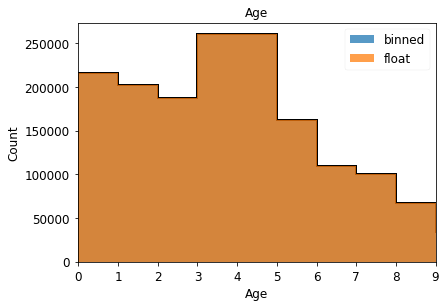

In [6]:
fig, ax = plt.subplots()

plt.hist(age_binned.numpy()[:,0], bins=10, alpha=1, color='k', histtype='step', linewidth=2)
plt.hist(age_binned.numpy()[:,0], bins=10, alpha=0.75, linewidth=2, label='binned')

plt.hist(age.numpy()[:,0]/9, bins=10, alpha=1, color='k', histtype='step', linewidth=2)
plt.hist(age.numpy()[:,0]/9, bins=10, alpha=0.75, linewidth=2, label='float')

#plt.yscale('log')
plt.xlim(0,9)
plt.title("Age")
plt.ylabel("Count")
plt.xlabel("Age")
plt.legend()
plt.show()

In [7]:
x = torch.cat((gender_onehot, relationship_onehot, worker_onehot, household_income_onehot, household_size, household_workers, household_vehicles), dim=1)
y = age #age_binned[:,0]

print(x.shape, x.dtype)
print(y.shape, y.dtype)

torch.Size([1601330, 25]) torch.float32
torch.Size([1601330, 1]) torch.float32


train/test split

In [8]:
## create a train/test split by household
household_ids = list(set(list(node_attributes['household_id'])))
np.random.shuffle(household_ids)

ntrain_households = int(0.8 * len(household_ids))
households_train = household_ids[:ntrain_households]
households_test = household_ids[ntrain_households:]
print('number of distinct households: %i' %len(household_ids))
print('number of training households: %i' %len(households_train))
print('number of testing households: %i' %len(households_test))

train_mask = torch.IntTensor(node_attributes['household_id'].isin(households_train)).type(torch.int64)
test_mask = torch.IntTensor(node_attributes['household_id'].isin(households_test)).type(torch.int64)
train_idx = np.arange(len(node_attributes))[train_mask == 1]
test_idx = np.arange(len(node_attributes))[test_mask == 1]

print('size of training set: %i' %torch.sum(train_mask).item())
print('size of testing set: %i' %torch.sum(test_mask).item())
print('percent train: %.2f' %(torch.sum(train_mask).item()/len(train_mask)))

number of distinct households: 632626
number of training households: 506100
number of testing households: 126526
size of training set: 1279922
size of testing set: 321408
percent train: 0.80


save

In [12]:
torch.save(x, '../../data/NDSSL data/raw/x.pt')
torch.save(y, '../../data/NDSSL data/raw/y.pt')
torch.save(train_mask, '../../data/NDSSL data/raw/train_mask.pt')
torch.save(test_mask, '../../data/NDSSL data/raw/test_mask.pt')
torch.save(train_idx, '../../data/NDSSL data/raw/train_idx.pt')
torch.save(test_idx, '../../data/NDSSL data/raw/test_idx.pt')

## Node classification: MLP 

In [10]:
full_set = torch.utils.data.TensorDataset(x, y)
train_set = torch.utils.data.Subset(full_set, train_idx)
test_set = torch.utils.data.Subset(full_set, test_idx)

In [11]:
class mlp(torch.nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(mlp, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_classes = num_classes
        self.fc1 = torch.nn.Linear(self.input_size, self.hidden_size)
        self.fc2 = torch.nn.Linear(self.hidden_size, self.hidden_size)
        self.fc3 = torch.nn.Linear(self.hidden_size, self.num_classes)
        self.relu = torch.nn.ReLU()
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        x = self.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.fc3(x)    
        #x = x.log_softmax(dim=-1)
        return x

In [12]:
def train():
    model.train()

    total_loss = total_examples = 0
    for x_batch, y_batch in train_loader:
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)
        optimizer.zero_grad()
        out = model(x_batch)
        #loss = F.nll_loss(out, y_batch) #torch.nn.MSELoss(size_average=None, reduce=None, reduction='mean')
        loss = nn.MSELoss()(out, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * x_batch.shape[0]
        total_examples += x_batch.shape[0]
    
    return total_loss/total_examples


@torch.no_grad()
def test_accuracy():
    model.eval()
    
    ## train accuracy
    total_examples = correct = 0.0
    for x_batch, y_batch in train_loader:
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)
        out = model(x_batch)
        total_examples += out.shape[0]
        correct += torch.sum(torch.argmax(out, axis=1) == y_batch).cpu().item()
    train_accuracy = correct/total_examples
    
    ## test accuracy
    total_examples = correct = 0.0
    for x_batch, y_batch in test_loader:
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)
        out = model(x_batch)
        total_examples += x_batch.shape[0]
        correct += torch.sum(torch.argmax(out, axis=1) == y_batch).cpu().item()
    test_accuracy = correct/total_examples
    
    return train_accuracy, test_accuracy

@torch.no_grad()
def test_loss():
    model.eval()
    
    ## train loss
    train_loss = 0.0
    train_examples = 0
    for x_batch, y_batch in train_loader:
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)
        out = model(x_batch)
        train_examples += x_batch.shape[0]
        train_loss += nn.MSELoss()(out, y_batch) * x_batch.shape[0]
    train_loss = train_loss/train_examples
    
    ## test loss
    test_loss = 0.0
    test_examples = 0
    for x_batch, y_batch in train_loader:
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)
        out = model(x_batch)
        test_examples += x_batch.shape[0]
        test_loss += nn.MSELoss()(out, y_batch) * x_batch.shape[0]
    test_loss = test_loss/test_examples
    
    return train_loss, test_loss

**Question: why is this so slow, even with a GPU?**

In [ ]:
model = mlp(x.shape[1], 1000, len(set(age_binned.numpy()[:,0])))
model = model.to(device)

optimizer = torch.optim.SGD(model.parameters(), lr = 1e-3)
print('number of trainable parameters %i' %sum(p.numel() for p in model.parameters() if p.requires_grad))

epochs = 50
batch_size = 1000
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=True)

for epoch in range(0, epochs):
    loss = train()
    #accs = test_accuracy()
    losses = test_loss()
    print(f'Epoch: {epoch+1:02d}, Loss: {loss:.4f}, Train: {losses[0]:.4f}, 'f'Test: {losses[1]:.4f}')

number of trainable parameters 1038011
Epoch: 01, Loss: 164.1530, Train: 118.4091, Test: 118.4091
Epoch: 02, Loss: 126.7217, Train: 116.6967, Test: 116.6967
Epoch: 03, Loss: 122.2368, Train: 114.8781, Test: 114.8781
Epoch: 04, Loss: 118.4757, Train: 108.6051, Test: 108.6051
Epoch: 05, Loss: 115.5760, Train: 105.6334, Test: 105.6334
Epoch: 06, Loss: 113.8171, Train: 104.5162, Test: 104.5162
Epoch: 07, Loss: 112.5084, Train: 103.5413, Test: 103.5413
Epoch: 08, Loss: 111.5861, Train: 103.1921, Test: 103.1921
Epoch: 09, Loss: 110.6563, Train: 102.4255, Test: 102.4256
Epoch: 10, Loss: 110.0457, Train: 102.4449, Test: 102.4449
Epoch: 11, Loss: 109.4266, Train: 101.6750, Test: 101.6750


## Node classification: Message Passing NNs

In [13]:
class NDSSLDataset(InMemoryDataset):
    def __init__(self, root, transform=None, pre_transform=None):
        super(NDSSLDataset, self).__init__(root, transform, pre_transform)
        self.data, self.slices = torch.load(self.processed_paths[0])
        
    @property
    def raw_file_names(self):
        return ['edge_list.csv', 'x.pt', 'y.pt', 'train_mask.pt', 'test_mask.pt', 'edge_attributes.csv']

    @property
    def processed_file_names(self):
        return ['NDSSL_graph_full_worker.pt']

    def process(self):
        data_list = []
        
        ## load the edge list
        edge_list = pd.read_csv(self.raw_paths[0], dtype=int) - 2000000 #the node id's start at 2000000, shift these to start at 0         
        
        ## format the edge list
        target_nodes = edge_list.iloc[:,0].values
        source_nodes = edge_list.iloc[:,1].values
        edge_index = torch.tensor([source_nodes, target_nodes], dtype=torch.int64)

        ## load the (x,y) formatted data
        x = torch.load(self.raw_paths[1], map_location=torch.device('cpu'))
        y = torch.load(self.raw_paths[2], map_location=torch.device('cpu'))
        train_mask = torch.load(self.raw_paths[3], map_location=torch.device('cpu')) == 1 
        test_mask = torch.load(self.raw_paths[4], map_location=torch.device('cpu')) == 1 

        ## set the edge weights to be the duration (in hours)
        edge_attributes = pd.read_csv(self.raw_paths[5])['duration'].values/3600
        duration =  torch.FloatTensor(edge_attributes)
        ## previous approaches used the degree:
        #row, col = data.edge_index
        #data.edge_attr = (1. / degree(col, data.num_nodes)[col]).double()
        
        ## build the data
        data = Data(edge_index=edge_index, x=x, y=y, train_mask=train_mask, test_mask=test_mask)
        data.edge_weight = duration
        data.train_mask = train_mask
        data.test_mask = test_mask
        #data.train_mask = torch.cat((torch.ones(n_train, dtype=torch.bool), torch.zeros(n_val, dtype=torch.bool), torch.zeros(n_test, dtype=torch.bool)), dim=0)
        #data.test_mask = torch.cat((torch.zeros(n_train, dtype=torch.bool), torch.zeros(n_val, dtype=torch.bool), torch.ones(n_test, dtype=torch.bool)), dim=0)

        print(data.__dict__)
        data, slices = self.collate([data])
        torch.save((data, slices), self.processed_paths[0])

In [14]:
## remove old processed files
import shutil
shutil.rmtree('../../data/NDSSL data/processed')

## shuffle the masks
dataset = NDSSLDataset('../../data/NDSSL data/')
dataset.process()
data = dataset[0]

Processing...
{'x': tensor([[1., 0., 1.,  ..., 3., 2., 3.],
        [0., 1., 1.,  ..., 3., 2., 3.],
        [1., 0., 0.,  ..., 3., 2., 3.],
        ...,
        [1., 0., 0.,  ..., 8., 1., 2.],
        [0., 1., 1.,  ..., 1., 1., 1.],
        [0., 1., 1.,  ..., 1., 0., 1.]]), 'edge_index': tensor([[      0,       0,       1,  ..., 1486224, 1378614, 1556530],
        [      1,       2,       2,  ..., 1601329, 1601329, 1601329]]), 'edge_attr': None, 'y': tensor([[42.],
        [43.],
        [17.],
        ...,
        [ 0.],
        [60.],
        [79.]]), 'pos': None, 'norm': None, 'face': None, 'train_mask': tensor([True, True, True,  ..., True, True, True]), 'test_mask': tensor([False, False, False,  ..., False, False, False]), 'edge_weight': tensor([10.9161, 12.7494, 12.5828,  ...,  0.0497,  0.1667,  0.1667])}
Done!
{'x': tensor([[1., 0., 1.,  ..., 3., 2., 3.],
        [0., 1., 1.,  ..., 3., 2., 3.],
        [1., 0., 0.,  ..., 3., 2., 3.],
        ...,
        [1., 0., 0.,  ..., 8., 1

In [15]:
dataset.__dict__

{'root': '../../data/NDSSL data',
 'transform': None,
 'pre_transform': None,
 'pre_filter': None,
 '__indices__': None,
 'data': Data(edge_index=[2, 19681821], edge_weight=[19681821], test_mask=[1601330], train_mask=[1601330], x=[1601330, 25], y=[1601330, 1]),
 'slices': {'x': tensor([      0, 1601330]),
  'edge_index': tensor([       0, 19681821]),
  'y': tensor([      0, 1601330]),
  'train_mask': tensor([      0, 1601330]),
  'test_mask': tensor([      0, 1601330]),
  'edge_weight': tensor([       0, 19681821])}}

Note: I was initially having a hard time with GraphSAINT, and even for a simple example using the CORA dataset. My computer was crashing after pytorch ate up all the RAM. I believe this is realted to [this issue](https://github.com/rusty1s/pytorch_geometric/issues/1331). The problem was fixed when I set `num_workers=0`.

In [16]:
loader = GraphSAINTRandomWalkSampler(data, batch_size=6000, walk_length=2,
                                     num_steps=5, sample_coverage=10,
                                     save_dir=dataset.processed_dir,
                                     num_workers=0)

Compute GraphSAINT normalization: : 17831578it [00:13, 1348345.44it/s]                            


### GCN

documentation: https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html?highlight=GCNConv#torch_geometric.nn.conv.GCNConv

In [40]:
class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GCN, self).__init__()
        in_channels = dataset.num_node_features
        out_channels = dataset.num_classes
        self.conv1 = GCNConv(in_channels, hidden_channels) 
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)
        self.lin = torch.nn.Linear(hidden_channels, out_channels)
        
    def forward(self, x, edge_index, edge_weight=None):
        x = F.relu(self.conv1(x, edge_index, edge_weight))
        x = F.dropout(x, p=0.2, training=self.training)
        x = F.relu(self.conv2(x, edge_index, edge_weight))
        x = F.dropout(x, p=0.2, training=self.training)
        x = F.relu(self.conv3(x, edge_index, edge_weight))
        x = F.dropout(x, p=0.2, training=self.training)
        x = self.lin(x)
        #x = x.log_softmax(dim=-1)
        return x

In [45]:
model = GCN(1000).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
print('number of trainable parameters %i' %sum(p.numel() for p in model.parameters() if p.requires_grad))

number of trainable parameters 2029001


In [46]:
def train():
    model.train()

    total_loss = total_examples = 0
    for data in loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data.x, data.edge_index, data.edge_weight)
        batch_size = out[data.train_mask].shape[0]
        loss = nn.MSELoss()(out[data.train_mask], data.y[data.train_mask]) #F.nll_loss(out[data.train_mask], data.y[data.train_mask])
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * batch_size
        total_examples += batch_size
    return total_loss / total_examples


@torch.no_grad()
def test_accuracy():
    model.eval()
    
    total_examples_train = correct_train = 0.0
    total_examples_test = correct_test = 0.0    
    for data in loader:
        data = data.to(device)
        out = model(data.x, data.edge_index, data.edge_weight)
        
        ## evaluate the train/test accuracies
        train_mask = data.train_mask
        test_mask = data.test_mask
        total_examples_train += torch.sum(train_mask).item()
        total_examples_test += torch.sum(test_mask).item()
        correct = (torch.argmax(out, axis=1) == data.y)
        
        correct_train += torch.sum(correct * train_mask).cpu().item()        
        correct_test += torch.sum(correct * test_mask).cpu().item()        
    
    overall_accuracy_train = correct_train/total_examples_train    
    overall_accuracy_test = correct_test/total_examples_test    
    
    return overall_accuracy_train, overall_accuracy_test


@torch.no_grad()
def test_loss():
    model.eval()
    
    total_examples_train = correct_train = 0.0
    total_examples_test = correct_test = 0.0    
    for data in loader:
        data = data.to(device)
        out = model(data.x, data.edge_index, data.edge_weight)
        
        ## evaluate the train/test accuracies
        train_mask = data.train_mask
        test_mask = data.test_mask
        total_examples_train += torch.sum(train_mask).item()
        total_examples_test += torch.sum(test_mask).item()
        
        loss = nn.MSELoss()(out, data.y)
        loss_train = (loss * train_mask)
        loss_test = (loss * test_mask)
    
    return loss_train, loss_test

In [49]:
for epoch in range(50):
    loss = train()
    accs = test_loss()
    print(f'Epoch: {epoch+1:02d}, Loss: {loss:.4f}, Train: {accs[0]:.4f}, 'f'Test: {accs[1]:.4f}')

TypeError: unsupported format string passed to Tensor.__format__

In [ ]:
for data in loader:
    data = data.to(device)
    out = model(data.x, data.edge_index, data.edge_weight)
    break

### GraphSAGE

In [21]:
class SAGE(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(SAGE, self).__init__()
        in_channels = dataset.num_node_features
        out_channels = dataset.num_classes
        self.conv1 = SAGEConv(in_channels, hidden_channels) 
        self.conv2 = SAGEConv(hidden_channels, hidden_channels)
        self.conv3 = SAGEConv(hidden_channels, hidden_channels)
        self.lin = torch.nn.Linear(3 * hidden_channels, out_channels)
        
    def set_aggr(self, aggr):
        self.conv1.aggr = aggr
        self.conv2.aggr = aggr
        self.conv3.aggr = aggr

    def forward(self, x0, edge_index, edge_weight=None):
        x1 = F.relu(self.conv1(x0, edge_index, edge_weight))
        x1 = F.dropout(x1, p=0.2, training=self.training)
        
        x2 = F.relu(self.conv2(x1, edge_index, edge_weight))
        x2 = F.dropout(x2, p=0.2, training=self.training)
        
        x3 = F.relu(self.conv3(x2, edge_index, edge_weight))
        x3 = F.dropout(x3, p=0.2, training=self.training)
        
        x = torch.cat([x1, x2, x3], dim=-1)
        x = self.lin(x)
        
        return x #x.log_softmax(dim=-1)

In [22]:
model = SAGE(1000).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
print('number of trainable parameters %i' %sum(p.numel() for p in model.parameters() if p.requires_grad))

number of trainable parameters 4056001


In [23]:
def train():
    model.train()

    total_loss = total_examples = 0
    for data in loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data.x, data.edge_index, data.edge_weight)
        batch_size = out[data.train_mask].shape[0]
        loss = nn.MSELoss()(out[data.train_mask], data.y[data.train_mask]) #F.nll_loss(out[data.train_mask], data.y[data.train_mask])
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * batch_size
        total_examples += batch_size
    return total_loss / total_examples


@torch.no_grad()
def test():
    model.eval()
    model.set_aggr('mean')
    
    total_examples_train = correct_train = 0.0
    total_examples_test = correct_test = 0.0    
    for data in loader:
        data = data.to(device)
        out = model(data.x, data.edge_index)#, data.edge_weight)
        
        ## evaluate the train/test accuracies
        train_mask = data.train_mask
        test_mask = data.test_mask
        total_examples_train += torch.sum(train_mask).item()
        total_examples_test += torch.sum(test_mask).item()
        correct = (torch.argmax(out, axis=1) == data.y)
        
        correct_train += torch.sum(correct * train_mask).cpu().item()        
        correct_test += torch.sum(correct * test_mask).cpu().item()        
    
    overall_accuracy_train = correct_train/total_examples_train    
    overall_accuracy_test = correct_test/total_examples_test    
    
    return overall_accuracy_train, overall_accuracy_test

In [24]:
for epoch in range(50):
    loss = train()
    accs = test()
    print(f'Epoch: {epoch+1:02d}, Loss: {loss:.4f}, Train: {accs[0]:.4f}, 'f'Test: {accs[1]:.4f}')

Epoch: 01, Loss: 1589.7677, Train: 235.9798, Test: 236.0897
Epoch: 02, Loss: 1437.1159, Train: 248.9879, Test: 249.0423
Epoch: 03, Loss: 1241.5081, Train: 232.1442, Test: 232.3878
Epoch: 04, Loss: 1015.4713, Train: 244.0024, Test: 244.0045
Epoch: 05, Loss: 835.5197, Train: 237.3943, Test: 237.4306
Epoch: 06, Loss: 808.9143, Train: 238.1822, Test: 238.2721
Epoch: 07, Loss: 811.4684, Train: 239.4648, Test: 239.2123
Epoch: 08, Loss: 747.7600, Train: 231.2643, Test: 230.9504
Epoch: 09, Loss: 712.8136, Train: 227.7885, Test: 227.8442
Epoch: 10, Loss: 694.1336, Train: 229.9792, Test: 230.0539
Epoch: 11, Loss: 661.3461, Train: 229.2236, Test: 229.1011
Epoch: 12, Loss: 631.4715, Train: 249.7536, Test: 250.0268
Epoch: 13, Loss: 608.5482, Train: 235.5926, Test: 235.6380
Epoch: 14, Loss: 575.5143, Train: 245.1803, Test: 245.2773
Epoch: 15, Loss: 549.3979, Train: 233.9833, Test: 234.0651
Epoch: 16, Loss: 518.0651, Train: 230.4202, Test: 230.3286
Epoch: 17, Loss: 492.4666, Train: 233.4544, Test: 23

In [ ]:
## confusion matrix

In [ ]:
1/117